# Load in the necessary imports

In [1]:
from __future__ import division
from tqdm import notebook

import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

plt.rcParams["figure.figsize"] = 16, 10
plt.style.use("fivethirtyeight")

sns.set(style="whitegrid", palette="muted", font_scale=1.5)

# BML model setup

## Function:
- <span style="color:blue"> **coord_incr:**</span> Calculates and returns the incremented coordinate. This also accounts for the edges that wrap or otherwise loop across the grid.
    - <span style="color:green"> **Parameters:**</span>
        - <span style="color:red"> **coord (int):**</span> An x or y coordinate.
        - <span style="color:red"> **coord_max (int):**</span> The maximum value alongside either the x or y axis.

In [2]:
def coord_incr(coord, coord_max):
    if coord == coord_max:
        return 0
    else:
        return coord + 1

## Class - Car:
- Represents either of the red or blue cars notated in the Biham-Middleton-Levine model.

## Parameters:
- <span style="color:red"> **car_id (int):**</span> A unique ID attributed to each individual car.
- <span style="color:red"> **color (string):**</span> The color of the car - can be either "red" or "blue".
- <span style="color:red"> **x_coord (int):**</span> The x-coordinate of the car's starting location.
- <span style="color:red"> **y_coord (int):**</span> The y-coordinate of the car's starting location.
- <span style="color:red"> **move_count (int):**</span> The number of steps a car has taken.

## Functions:
- <span style="color:blue"> **get_location:**</span> Returns the current (x, y) coordinates of the car.
- <span style="color:blue"> **move_car:**</span> Moves the cars one step forward. Red cars move rightwards while blue cars move downwards.
    - <span style="color:green"> **Parameters:**</span>
        - <span style="color:red"> **row_max (int):**</span> The number of maximum rows that belong to the grid.
        - <span style="color:red"> **col_max (int):**</span> The number of maximum columns that belong to the grid>

In [3]:
class Car(object):
    def __init__(self, car_id, color, x_coord, y_coord):
        self.car_id = car_id
        self.color = color
        self.x = x_coord
        self.y = y_coord
        self.move_count = 0

    def __repr__(self):
        return "id: {0}, color: {1}, location: {2}".format(self.car_id, self.color, self.get_location())

    def get_location(self):
        return (self.x, self.y)

    def move_car(self, row_max, col_max):
        if self.color == "red":
            self.x = coord_incr(self.x, col_max)
        else:
            self.y = coord_incr(self.y, row_max)
        self.move_count += 1

## Class - Grid:
- Represents the rectangular lattice in which cars move on during the execution of the BML model. In this model, blue cars move vertically downwards at odd time steps whereas red cars move horizontally rightwards at even time steps. When the cars are moving they have three options to consider:
    - The car can move into an empty location so we move.
    - The car tries to move into a location occupied by a car of the opposite color so we can't move.
    - The car tries to move into a location occupied by a car of the same color so we can't move and are blocked from moving.

## Parameters:
- <span style="color:red"> **X (int):**</span> Number of columns in the grid.
- <span style="color:red"> **Y (int):**</span> Number of rows in the grid.
- <span style="color:red"> **p (float):**</span> The density of the cars in the grid.
- <span style="color:red"> **r_prob (float) (int):**</span> The probability of a car being red instead of blue.

## Functions:
- <span style="color:blue"> **grid_coord:**</span> Returns an array containing all of the points in the grid.
- <span style="color:blue"> **is_jammed:**</span> Checks whether the system is currently jammed or not.
- <span style="color:blue"> **initialize_cars:**</span> Randomly initializes the starting positions of the cars on the grid.
- <span style="color:blue"> **get_new_location:**</span> Retrieves the new location of the car on the grid after it has made a move.
- <span style="color:blue"> **update_colors:**</span> Updates the color of the car that can make a move on the grid after the previous set of cars have made a move.
- <span style="color:blue"> **take_step:**</span> Undergo all of the actions associated with each iteration or otherwise time step 'n' of the BML model.
- <span style="color:blue"> **pad_filename:**</span> Pads the filenames of saved images with any number of leading 0s.
- <span style="color:blue"> **get_percent_moved:**</span> Get number of moves made at time step 'n'.
- <span style="color:blue"> **get_total_percent_moved:**</span> Get the total number of moves made throughout the simulation.
- <span style="color:blue"> **move_cars:**</span> Moves cars that can make a move.
    - <span style="color:green"> **Parameters:**</span>
        - <span style="color:red"> **cars_to_move (set):**</span> The coordinates of the cars to move.
- <span style="color:blue"> **run_simulation:**</span> Executes 'n' total time steps of the BML model.
    - <span style="color:green"> **Parameters:**</span>
        - <span style="color:red"> **n (int):**</span> The number of simulation time steps to take.
        - <span style="color:red"> **print_images (boolean):**</span> The choice of printing images of the simulation is optional - keep off to improve execution speed.
        - <span style="color:red"> **plot_freq (float):**</span> The frequency with which to take snapshots of the model over the course of the entire simulation.
- <span style="color:blue"> **plot:**</span> Plots the current positions of all the cars on the grid.
    - <span style="color:green"> **Parameters:**</span>
        - <span style="color:red"> **directory (string):**</span> The location of the directory with which to store images in.
        - <span style="color:red"> **digits (int):**</span> The number of 0s to pad the end of the filename with.

In [4]:
class Grid(object):
    def __init__(self, X, Y, p=None, r_prob=None):
        n_red = None
        n_blue = None
        n_cars = int(X * Y * p)

        self.n_red = np.random.binomial(n_cars, r_prob)
        self.n_blue = n_cars - self.n_red
        self.n_cars = self.n_red + self.n_blue

        # Used to store the locations of all the cars on the grid
        self.car_loc = {}

        # Used to set up the grid
        self.X = X - 1
        self.Y = Y - 1
        self.coords = self.grid_coord(X, Y)

        # Used to control which cars move at which time-step 'n'
        self.step = 0
        self.color_paused = "blue"
        self.color_move = "red"

        # Used to calculate values of interest
        self.is_Jammed = {"red": False, "blue": False}
        self.total_Movement = {"red": 0, "blue": 0}

        self.initialize_cars()

    def __repr__(self):
        return "red: {0}, blue: {1} \nrow: {2}, col: {3}".format(self.n_red, self.n_blue, self.X + 1, self.Y + 1)

    def grid_coord(self, row, col):
        return np.array([(X, Y) for X in range(row) for Y in range(col)])

    def is_jammed(self):
        return sum(self.is_Jammed.values()) == 2

    def initialize_cars(self):
        # Select starting positions of the cars at random
        init_coords = np.random.choice(len(self.coords), self.n_cars, replace=False)
        car_coords = self.coords[init_coords]

        # Assign the cars to these locations
        car_id = 1
        col = "red"
        for coord in car_coords:
            self.car_loc[tuple(coord)] = Car(car_id, col, coord[0], coord[1])

            if car_id == self.n_red:
                col = "blue"
            car_id += 1

    def get_new_location(self, x, y, color):
        if self.step % 2 == 0:
            if color == "red":
                x = coord_incr(x, self.Y)
        else:
            if color == "blue":
                y = coord_incr(y, self.X)
        return (x, y)

    def update_colors(self):
        if self.step % 2 == 0:
            self.color_move = "red"
            self.color_paused = "blue"
        else:
            self.color_move = "blue"
            self.color_paused = "red"

    def move_cars(self, cars_to_move):
        # Update the is_Jammed dictionary
        self.is_Jammed[self.color_move] = len(cars_to_move) == 0
        self.total_Movement[self.color_move] = len(cars_to_move)

        # Prevent data from being overwritten
        loc_copy = self.car_loc.copy()

        # Keep track of all new locations
        new_locations = set()
        for loc in cars_to_move:
            Y = loc_copy[loc]

            # Move the car and record its new location
            Y.move_car(self.X, self.Y)
            new_loc = Y.get_location()

            # Update the location of the car in the car_loc dictionary
            self.car_loc[new_loc] = Y
            new_locations.add(new_loc)
        # Delete old locations that are NOT new locations
        for loc in cars_to_move.difference(new_locations):
            del self.car_loc[loc]

    def take_step(self):
        self.step += 1
        self.update_colors()

        # Record the locations of all the cars
        visited = set()
        to_move = []
        possible_moves = []
        for (x, y), v in self.car_loc.items():
            if ((x, y) in visited) or (v.color == self.color_paused):
                continue
            visited.add((x, y))
            possible_moves.append((x, y))

            # Get the location the car is planning to move to
            new_loc = self.get_new_location(x, y, v.color)

            # If the new location is empty, move the car
            if new_loc not in self.car_loc:
                to_move.extend(possible_moves)
                possible_moves = []
            else:
                # If instead there is a car in the new location - get the color of that car and if that color
                # is the paused colors then the cars can't move
                while new_loc in self.car_loc:
                    visited.add(new_loc)
                    car_color = self.car_loc[new_loc].color
                    dup = len(set(possible_moves)) < len(possible_moves)

                    # Exit the loop if none of the cars can move
                    if (car_color == self.color_paused) or dup:
                        possible_moves = []
                        break
                    possible_moves.append(new_loc)
                    new_loc = self.get_new_location(new_loc[0], new_loc[1], car_color)
                # Exit the loop if all points found are a possible move
                else:
                    to_move.extend(possible_moves)
                    possible_moves = []
        # Move all the cars
        self.move_cars(set(to_move))

    def run_simulation(self, print_images=False, n=100, directory="./images", plot_freq=0.1, update_freq=0.05):
        get_num = lambda n, x: max(int(n * x), 1)

        if plot_freq > 1:
            plot_num = plot_freq
        else:
            plot_num = get_num(n, plot_freq)
        if print_images == True:
            for i in range(n):
                if i % plot_num == 0:
                    self.plot(directory=directory)
                self.take_step()

                if self.is_jammed():
                    print("Traffic jam occured at time step = " + str(i))
                    self.plot(directory=directory)
                    break
        else:
            for i in range(n):
                self.take_step()

                if self.is_jammed():
                    print("Traffic jam occured at time step = " + str(i))
                    break

    def pad_filename(self, n, digits):
        n = str(n)
        mult = digits - len(n)
        return "0" * mult + n

    def plot(self, directory="./images", file_num=None, digits=5):
        coord_col = [(x, y, v.color) for (x, y), v in self.car_loc.items()]
        coord_col = pd.DataFrame(coord_col, columns=["x", "y", "color"])

        # Create scatter plot by car color
        coord_col.plot(kind="scatter", x="x", y="y", c=coord_col["color"], figsize=(12, 8))

        plt.gca().set_axis_off()
        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
        plt.margins(0.01, 0.01)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.title("Simulation Step: {0}".format(self.step))

        if not file_num:
            file_num = self.pad_filename(self.step, digits)
        if not os.path.exists(directory):
            os.makedirs(directory)
        filename = "{0}/Simulation_step_{1}.png".format(directory, file_num)
        plt.savefig(filename)
        plt.close()

    def get_percent_moved(self):
        total_Movement = sum(self.total_Movement.values())
        total_cars = self.n_red + self.n_blue
        percent_moved = total_Movement / total_cars
        return percent_moved

    def get_total_percent_moved(self):
        total_move = int(sum([c.move_count for c in self.car_loc.values()]))
        possible_moves = int(self.n_red * self.step / 2 + self.n_blue * self.step / 2)
        total_percent_moved = round(total_move * 100 / possible_moves, 1)
        return total_percent_moved

# Batch simulation hyperparameter setup

In [5]:
param_label = "D"
param_list = np.arange(0.05, 0.75, 0.025)
test_results = {param_label: [], "Percent moved": [], "Movements / Possible movements": [], "Step jammed": []}

itera = 1
totalPM = 0
totalTPM = 0
averageJam = 0
averageJamC = 0

# Execute batch simulations

In [6]:
tic = time.time()
for param in notebook.tqdm(param_list):
    while itera <= 5:
        g = Grid(150, 150, p=param, r_prob=0.3)
        g.run_simulation(n=1000, print_images=False)

        PM = g.get_percent_moved()
        TPM = g.get_total_percent_moved()

        if g.is_jammed() == True:
            averageJam = averageJam + (g.step - 1)
            averageJamC = averageJamC + 1
        totalPM = totalPM + PM
        totalTPM = totalTPM + TPM
        itera = itera + 1
    if averageJam > 0:
        averageJam = averageJam / averageJamC
    totalPM = totalPM / 5
    totalTPM = totalTPM / 5

    test_results[param_label].append(param)
    test_results["Percent moved"].append(totalPM)
    test_results["Movements / Possible movements"].append(totalTPM)

    if averageJam > 0:
        test_results["Step jammed"].append(averageJam)
    else:
        test_results["Step jammed"].append("N/A")
    itera = 1
    totalPM = 0
    totalTPM = 0
    averageJam = 0
    averageJamC = 0
toc = time.time()
print("Minutes taken = " + str((toc - tic) / 60.0))

test_results = pd.DataFrame(test_results)
test_results

Traffic jam occured at time step = 834
Traffic jam occured at time step = 792
Traffic jam occured at time step = 904
Traffic jam occured at time step = 818
Traffic jam occured at time step = 822
Traffic jam occured at time step = 961
Traffic jam occured at time step = 790
Traffic jam occured at time step = 482
Traffic jam occured at time step = 856
Traffic jam occured at time step = 453
Traffic jam occured at time step = 855
Traffic jam occured at time step = 896
Traffic jam occured at time step = 620
Traffic jam occured at time step = 604
Traffic jam occured at time step = 480
Traffic jam occured at time step = 373
Traffic jam occured at time step = 543
Traffic jam occured at time step = 432
Traffic jam occured at time step = 531
Traffic jam occured at time step = 317
Traffic jam occured at time step = 498
Traffic jam occured at time step = 582
Traffic jam occured at time step = 351
Traffic jam occured at time step = 446
Traffic jam occured at time step = 466
Traffic jam occured at ti

,D,Percent moved,Movements / Possible movements,Step jammed
0,0.050,0.997156,99.30,N/A
1,0.075,0.998696,99.08,N/A
2,0.100,0.992089,98.52,N/A
3,0.125,0.991750,98.36,N/A
4,0.150,0.988622,97.82,N/A
5,0.175,0.978969,97.08,N/A
6,0.200,0.983778,97.00,N/A
7,0.225,0.967365,96.04,N/A
8,0.250,0.969884,95.68,N/A
9,0.275,0.943430,93.74,N/A


# Plot P(c)

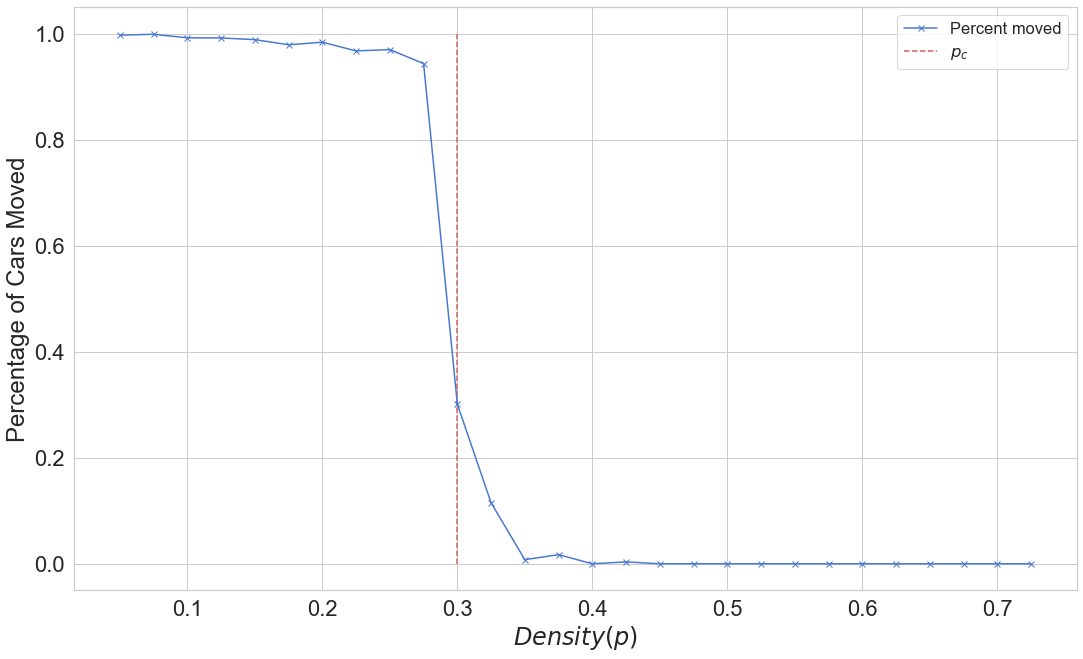

In [7]:
PC = test_results["Percent moved"].diff().fillna(0).idxmin()

ax = test_results.plot(x="D", y="Percent moved", style="bx-", grid=True)
plt.vlines(x=test_results.iloc[PC]["D"], ymin=0, ymax=1, color="r", linestyle="--", label=r"$p_c$")
plt.legend(loc="best")
ax.set_xlabel(r"$Density (p)$", fontsize=24)
ax.set_ylabel("Percentage of Cars Moved", fontsize=24)
ax.tick_params(axis="both", which="major", labelsize=22)
ax.tick_params(axis="both", which="minor", labelsize=22)

# Plot the average step at which the simulation jammed

In [8]:
test_results["Step jammed"] = test_results["Step jammed"].replace("N/A", 0)

In [9]:
test_results2 = test_results.copy()
test_results2.drop(test_results2.loc[test_results2["Step jammed"] == 0].index, inplace=True)

In [10]:
test_results2["Step jammed_average"] = test_results2["Step jammed"].rolling(3).mean().fillna(test_results2["Step jammed"].iloc[0])

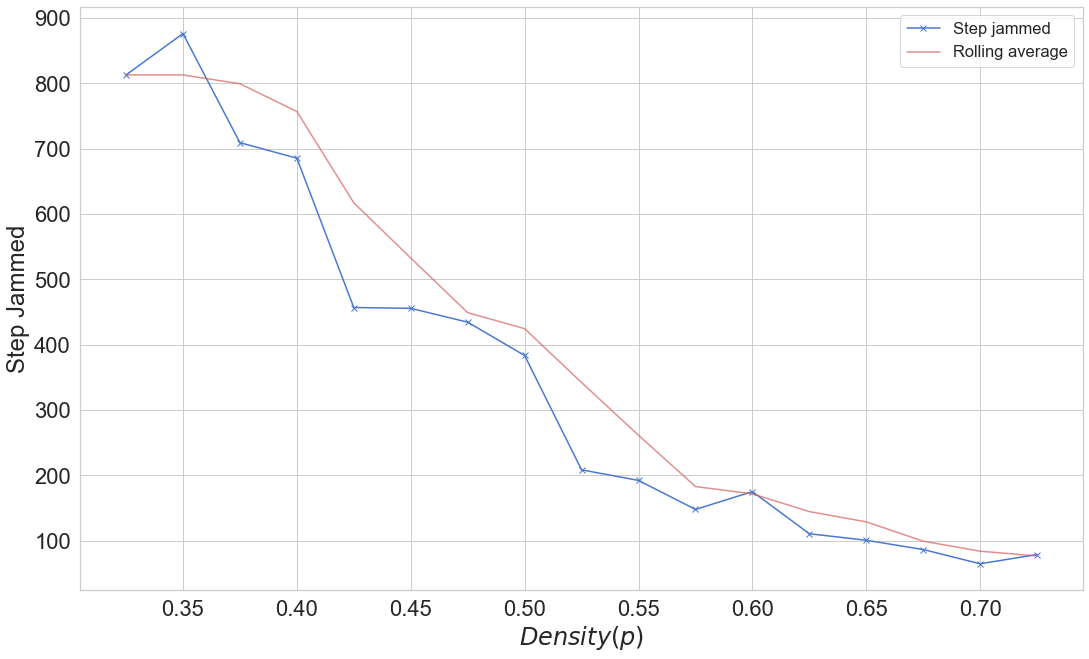

In [11]:
ax = test_results2.plot(x="D", y="Step jammed", style="bx-", grid=True)
plt.plot(test_results2["D"], test_results2["Step jammed_average"], color="r", alpha=0.7, label="Rolling average")
plt.legend(loc="best")
ax.set_xlabel(r"$Density (p)$", fontsize=24)
ax.set_ylabel("Step Jammed", fontsize=24)
ax.tick_params(axis="both", which="major", labelsize=22)
ax.tick_params(axis="both", which="minor", labelsize=22)

# Plot the percentage of moves made out of the total possible moves possible

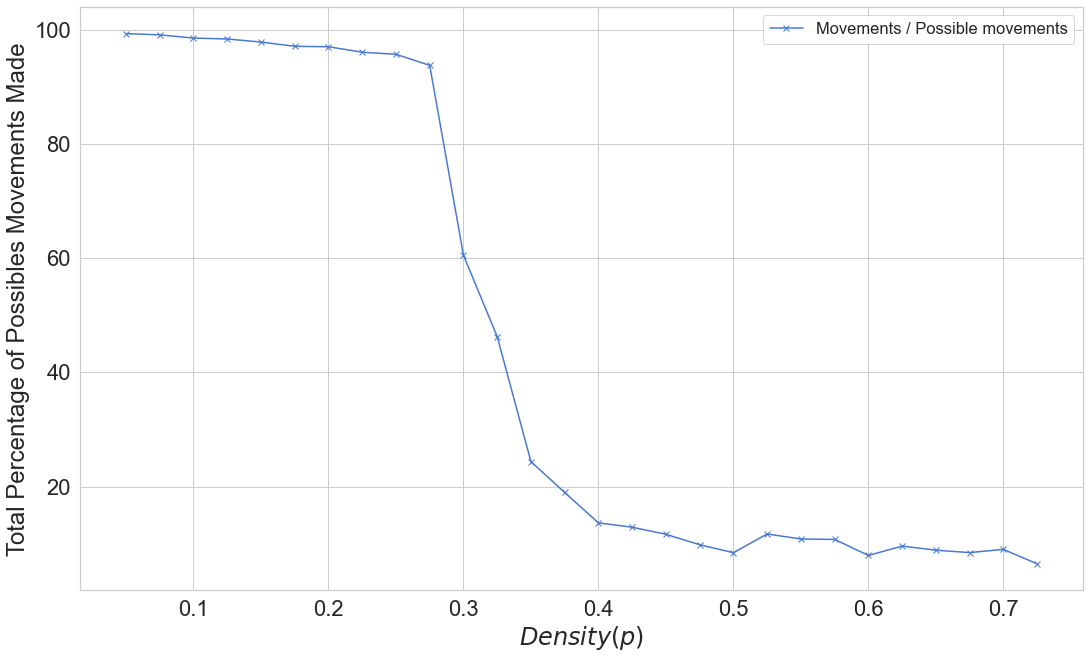

In [12]:
ax = test_results.plot(x="D", y="Movements / Possible movements", style="bx-", grid=True)
plt.legend(loc="best")
ax.set_xlabel(r"$Density (p)$", fontsize=24)
ax.set_ylabel("Total Percentage of Possibles Movements Made", fontsize=24)
ax.tick_params(axis="both", which="major", labelsize=22)
ax.tick_params(axis="both", which="minor", labelsize=22)